# ATP cost

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

In [3]:
from neuron import h, gui
import Model

In [4]:
model = Model.without_ih()

In [5]:
# Some special place
first_Bouton = model.boutons[0]
middle_Bouton = model.boutons[model.axNum//2]
middle_Axon = model.axons[model.axNum//2]

# Checking topology
s = h.Shape()
s.show(False)
s.color(2, sec=middle_Bouton)     # color middle bouton red
s.color(2, sec=middle_Axon)     # color middle axon red
s.color(3, sec=first_Bouton)     # color first_Bouton blue
# h.topology()

0.0

In [6]:
pre_interval = 1000.
sim_interval = 10.

In [7]:
stim = h.IClamp(first_Bouton(0.5))
stim.delay=pre_interval + 5    # stimulus delay in ms
stim.dur=0.5                   # stimulus duration in ms
stim.amp=200                   # stimulus amplitude in nA

In [8]:
# Record voltage and time
v = h.Vector()          # Membrane potential vector [mV]
t = h.Vector()          # Time stamp vector [ms]
v.record(middle_Bouton(0.5)._ref_v)
t.record(h._ref_t) 

Vector[4]

**Note on how to record the total sodium and potassium current**

https://www.neuron.yale.edu/phpBB/viewtopic.php?t=3844

**Question**: To get the sum of all the ion currents I_ion, can I just record 'segment._ref_ina' and 'segment._ref_ik', multiply them with area, and add them together? Are there other ways to directly get the sum of total ion currents?

**Ted**: Nope, that's the only way. Don't forget to include i_pas and ileak_hh. But you're not going to include pas, so just remember to add ileak_hh

In [9]:
# Record total sodium and potassium current densities at the middle bouton
ina = h.Vector()        # sodium current density vector [mA/cm ]
ik = h.Vector()         # potassium current density vector [mA/cm2]
ina.record(middle_Bouton(0.5)._ref_ina)   
ik.record(middle_Bouton(0.5)._ref_ik)      

Vector[6]

In [10]:
# Record total sodium current density at the middle axon
ina_axon = h.Vector()        # sodium current density vector [mA/cm ]
ina_axon.record(middle_Axon(0.5)._ref_ina)   

Vector[7]

In [11]:
h.tstop = pre_interval + sim_interval
h.dt = 0.01 #ms
h.run()
t.add(-pre_interval) # Discard the first 1000ms to equilibrate the membrane potential

Changed dt


Vector[4]

<Figure size 720x360 with 0 Axes>

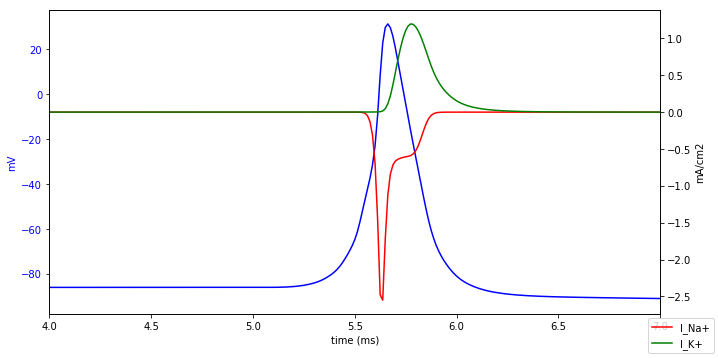

In [12]:
plt.figure() 

fig, ax1 = plt.subplots()

color = 'blue'
ax1.set_xlabel('time (ms)')
ax1.set_ylabel('mV', color=color)
ax1.plot(t, v, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'black'
ax2.set_ylabel('mA/cm2', color=color)  # we already handled the x-label with ax1
ax2.plot(t, ina, color='red', label='I_Na+')
ax2.plot(t, ik, color='green', label='I_K+')
ax2.tick_params(axis='y', labelcolor=color)

ax2.set_xlim((4,7))
#ax2.set_xlim((0,sim_interval))   
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend(loc=4)
plt.show()


In [13]:
def integrate_ina_atp (ina, t, tmin=5, tmax=10):

    # index for time interval
    index = np.logical_and(np_t >= tmin, np_t < tmax)   
    
    # Integrate sodium current
    na_charge = - np.trapz(np_ina[index], dx=h.dt)         # nA * ms = 10-12 As = 10-12 Coulomb = pC')
    
    # pico * number of electrons / coloumb * 1 ATP for pumping 3 Na+
    factor = 1e-12 * 6.2415090744e18 * 1/3   
    n_atp = int(factor*na_charge)   
    
    return na_charge, n_atp, tmax-tmin     

In [14]:
# Calculate for Bouton
print 'time step size = ', h.dt, 'ms'
print 'for one (middle) bouton:'
middle_Bouton_area = middle_Bouton(0.5).area()   
print '   area = ', middle_Bouton_area, 'um2'

ina.mul(middle_Bouton_area)   # mA/cm2*um2  = 10^-3 A * 10^+4 * 1^-12 = 10^-11 A
ina.mul(0.01)                 # now we have 10^-11 A / 10^-2 = 10^-9 A = nA

print '   maximum sodium current = ', ina.min(), 'nA (for sanity check)'

# Calculate for Axon
print 'for one (middle) axon:'
middle_Axon_area = middle_Axon(0.5).area()   
print '   area = ', middle_Axon_area, 'um2'

ina_axon.mul(middle_Axon_area)   # mA/cm2*um2  = 10^-3 A * 10^+4 * 1^-12 = 10^-11 A
ina_axon.mul(0.01)               # now we have 10^-11 A / 10^-2 = 10^-9 A = nA

print '   maximum sodium current = ', ina_axon.min(), 'nA (for sanity check)'

# Add 1 axon piece and 1 bouton, and save in numpy array for integration
np_ina = np.array(ina) + np.array(ina_axon)
np_t = np.array(t)

time step size =  0.0125 ms
for one (middle) bouton:
   area =  201.06192983 um2
   maximum sodium current =  -5.1306484405 nA (for sanity check)
for one (middle) axon:
   area =  17.5929191223 um2
   maximum sodium current =  -3.57401106725e-06 nA (for sanity check)


In [15]:
print 'before action potential:'
na_charge, n_atp, period = integrate_ina_atp(np_ina, np_t, tmin=0, tmax=5)    
print '   total sodium charge =', na_charge, 'pC' 
print '   number of ATP per AP = ',  n_atp
print '   period = ', period, 'ms'

print 'during action potential:'
na_charge, n_atp, period = integrate_ina_atp(np_ina, np_t, tmin=5, tmax=10)    
print '   total sodium charge =', na_charge, 'pC' 
print '   number of ATP per AP = ',  n_atp
print '   period = ', period, 'ms'



before action potential:
   total sodium charge = 0.002016919956339247 pC
   number of ATP per AP =  4196
   period =  5 ms
during action potential:
   total sodium charge = 0.47761560282136833 pC
   number of ATP per AP =  993680
   period =  5 ms


In [16]:
print 'combiend length = ', middle_Axon.L + middle_Bouton.L, 'um'

combiend length =  43.0 um
